# Unemployment Models
Brian Howard
26 July 2020

In [1]:
library(UsingR)
library(quantmod)
library(ggplot2)
library(grid)
library(gridExtra)
library(knitr)
library(kableExtra)
library(tools)
library(zoo)
library(signal)
library(stringr)
library(corrplot)
library(caret)
library(rpart)
library(rpart.plot)
library(randomForest)
library(Quandl)
library(nnet)
library(readr)
#library(devtools)
#install_github("andrewuhl/RollingWindow")
library(RollingWindow)
#install.packages("EIAdata")
library(EIAdata)
library(gtable)
library(data.table)
library(readxl)
library(plotly)

Warning message:
"package 'UsingR' was built under R version 3.6.3"
Loading required package: MASS

Loading required package: HistData

Warning message:
"package 'HistData' was built under R version 3.6.3"
Loading required package: Hmisc

Warning message:
"package 'Hmisc' was built under R version 3.6.3"
Loading required package: lattice

Loading required package: survival

Warning message:
"package 'survival' was built under R version 3.6.3"
Loading required package: Formula

Loading required package: ggplot2

Warning message:
"package 'ggplot2' was built under R version 3.6.3"

Attaching package: 'Hmisc'


The following objects are masked from 'package:base':

    format.pval, units



Attaching package: 'UsingR'


The following object is masked from 'package:survival':

    cancer


Warning message:
"package 'quantmod' was built under R version 3.6.3"
Loading required package: xts

Warning message:
"package 'xts' was built under R version 3.6.3"
Loading required package: zoo

Warnin

Call helper functions

In [2]:
source("plotHelper.r")

Define the source of the data (local or web) and whether to update the models.

In [3]:
b.refresh.models = FALSE

Define the plotting ranges and vertical defaults

In [4]:
dt.recent = as.Date("2017-01-01")
d.GSPC.max = 3500

Load up the off-line data

In [5]:
load("C:/Users/Rainy/OneDrive//RecessionIndicator_Buffer.RData")

This snippet is needed because some of the ticker symbols include are invalid variable names so re-cast those variable names.

In [6]:
df.symbols$string.symbol <-
  str_replace_all(df.symbols$string.symbol, "[^[:alnum:]]", "")

Do the interpolation to daily samples and tidy the data

In [7]:
source("calcInterpolate.r")

In [8]:
df.data <- calcInterpolate(df.data, df.symbols)

Warning message in merge.xts(xtsData, get(df.symbols$string.symbol[idx])):
"NAs introduced by coercion"


Truncate the data. A very few data series do go back to 1854, but most don't even go past WWII so truncate the dataframe

In [9]:
df.data1 <- df.data[as.Date(rownames(df.data)) > as.Date("1940-01-01"),]

Create aggreagate data series
Some analysis requires that two or more series be combined. For example, normallizing debt by GDP to get a sense of the proportion of debt to the total economy helps understand the debt cycle.

In [10]:
source("calcAggregateSeries.r")

Calculate the year-over-year, 50 day moving average, and other features in the data

In [11]:
source("calcFeatures.r")

In [ ]:
lst.df <- calcFeatures(df.data, df.symbols)
df.data <- lst.df[[1]]
df.symbols <- lst.df[[2]]

These are auxilliary series that use the YoY and smoothed data.

In [15]:
source("calcFeaturesAggregate.r")

Build the recession data frame

In [16]:
source("calcRecession.r")

## Unployment models

### Labor force normalization

The BLS statistics (U3, U6, etc.) calculates labor force by summing the number of employed and unemployed people (https://www.bls.gov/cps/lfcharacteristics.htm#laborforce). The problem is that when the survey is troubled, as it was during Covid19, the labor force shows a sudden drop. For example, during the Covid19 outbreak in the spring of 2020 the labor force dropped from 164MM to 155MM. In reality, the labor force did not really drop by this much. In other words there were approximately the same number of people who wanted to work on March 1st of 2020 as there were on June 1st of 2020.

This makes the BLS measures of labor force less useful when I want to normalized by working force population. To get around this I do a linear fit of BLS labor force to general U.S. population (POPTHM) and take the slope of that fit as the average labor force participation rate. I then multiply POPTHM this value to get a constant labor force rate. This has some drawbacks, especially in that it cannot account for demographic shifts. But it should be an okay first order approximation.

In [ ]:
dt.start.prediction <- as.Date(max(c(index(CLF16OV[1]), index(POPTHM[1]))))
dt.end.prediction <- as.Date("2020-01-01")

df.lf.model <-
  df.data[df.data$date >= dt.start.prediction &
            df.data$date <= dt.end.prediction,]

# Perform the fit
list.fit.clf16ovpopthm <- train(
  CLF16OV ~ POPTHM,
  data = df.lf.model,
  method = "lm",
  preProcess = c('center', 'scale')
)

In [ ]:
# Add linear prediction to the dataframe
str.symbol <- "CLF16OV.lm.POPTHM"
df.data[str.symbol] <-
  predict(list.fit.clf16ovpopthm, newdata = df.data)

# Add the linear model prediction to the symbols table
df.symbols <-
  rbind(
    df.symbols,
    data.frame(
      string.symbol = str.symbol,
      string.source = "Predict",
      string.description = "Linear Model Prediction\nCLF16OV given POPTHM",
      string.label.y = getPlotYLabel(df.symbols, "POPTHM")[1],
      float.expense.ratio = -1.00,
      Max030 = FALSE,
      Max180 = FALSE,
      date.series.start = dt.start.prediction,
      date.series.end = as.Date(Sys.Date())
    )
  )

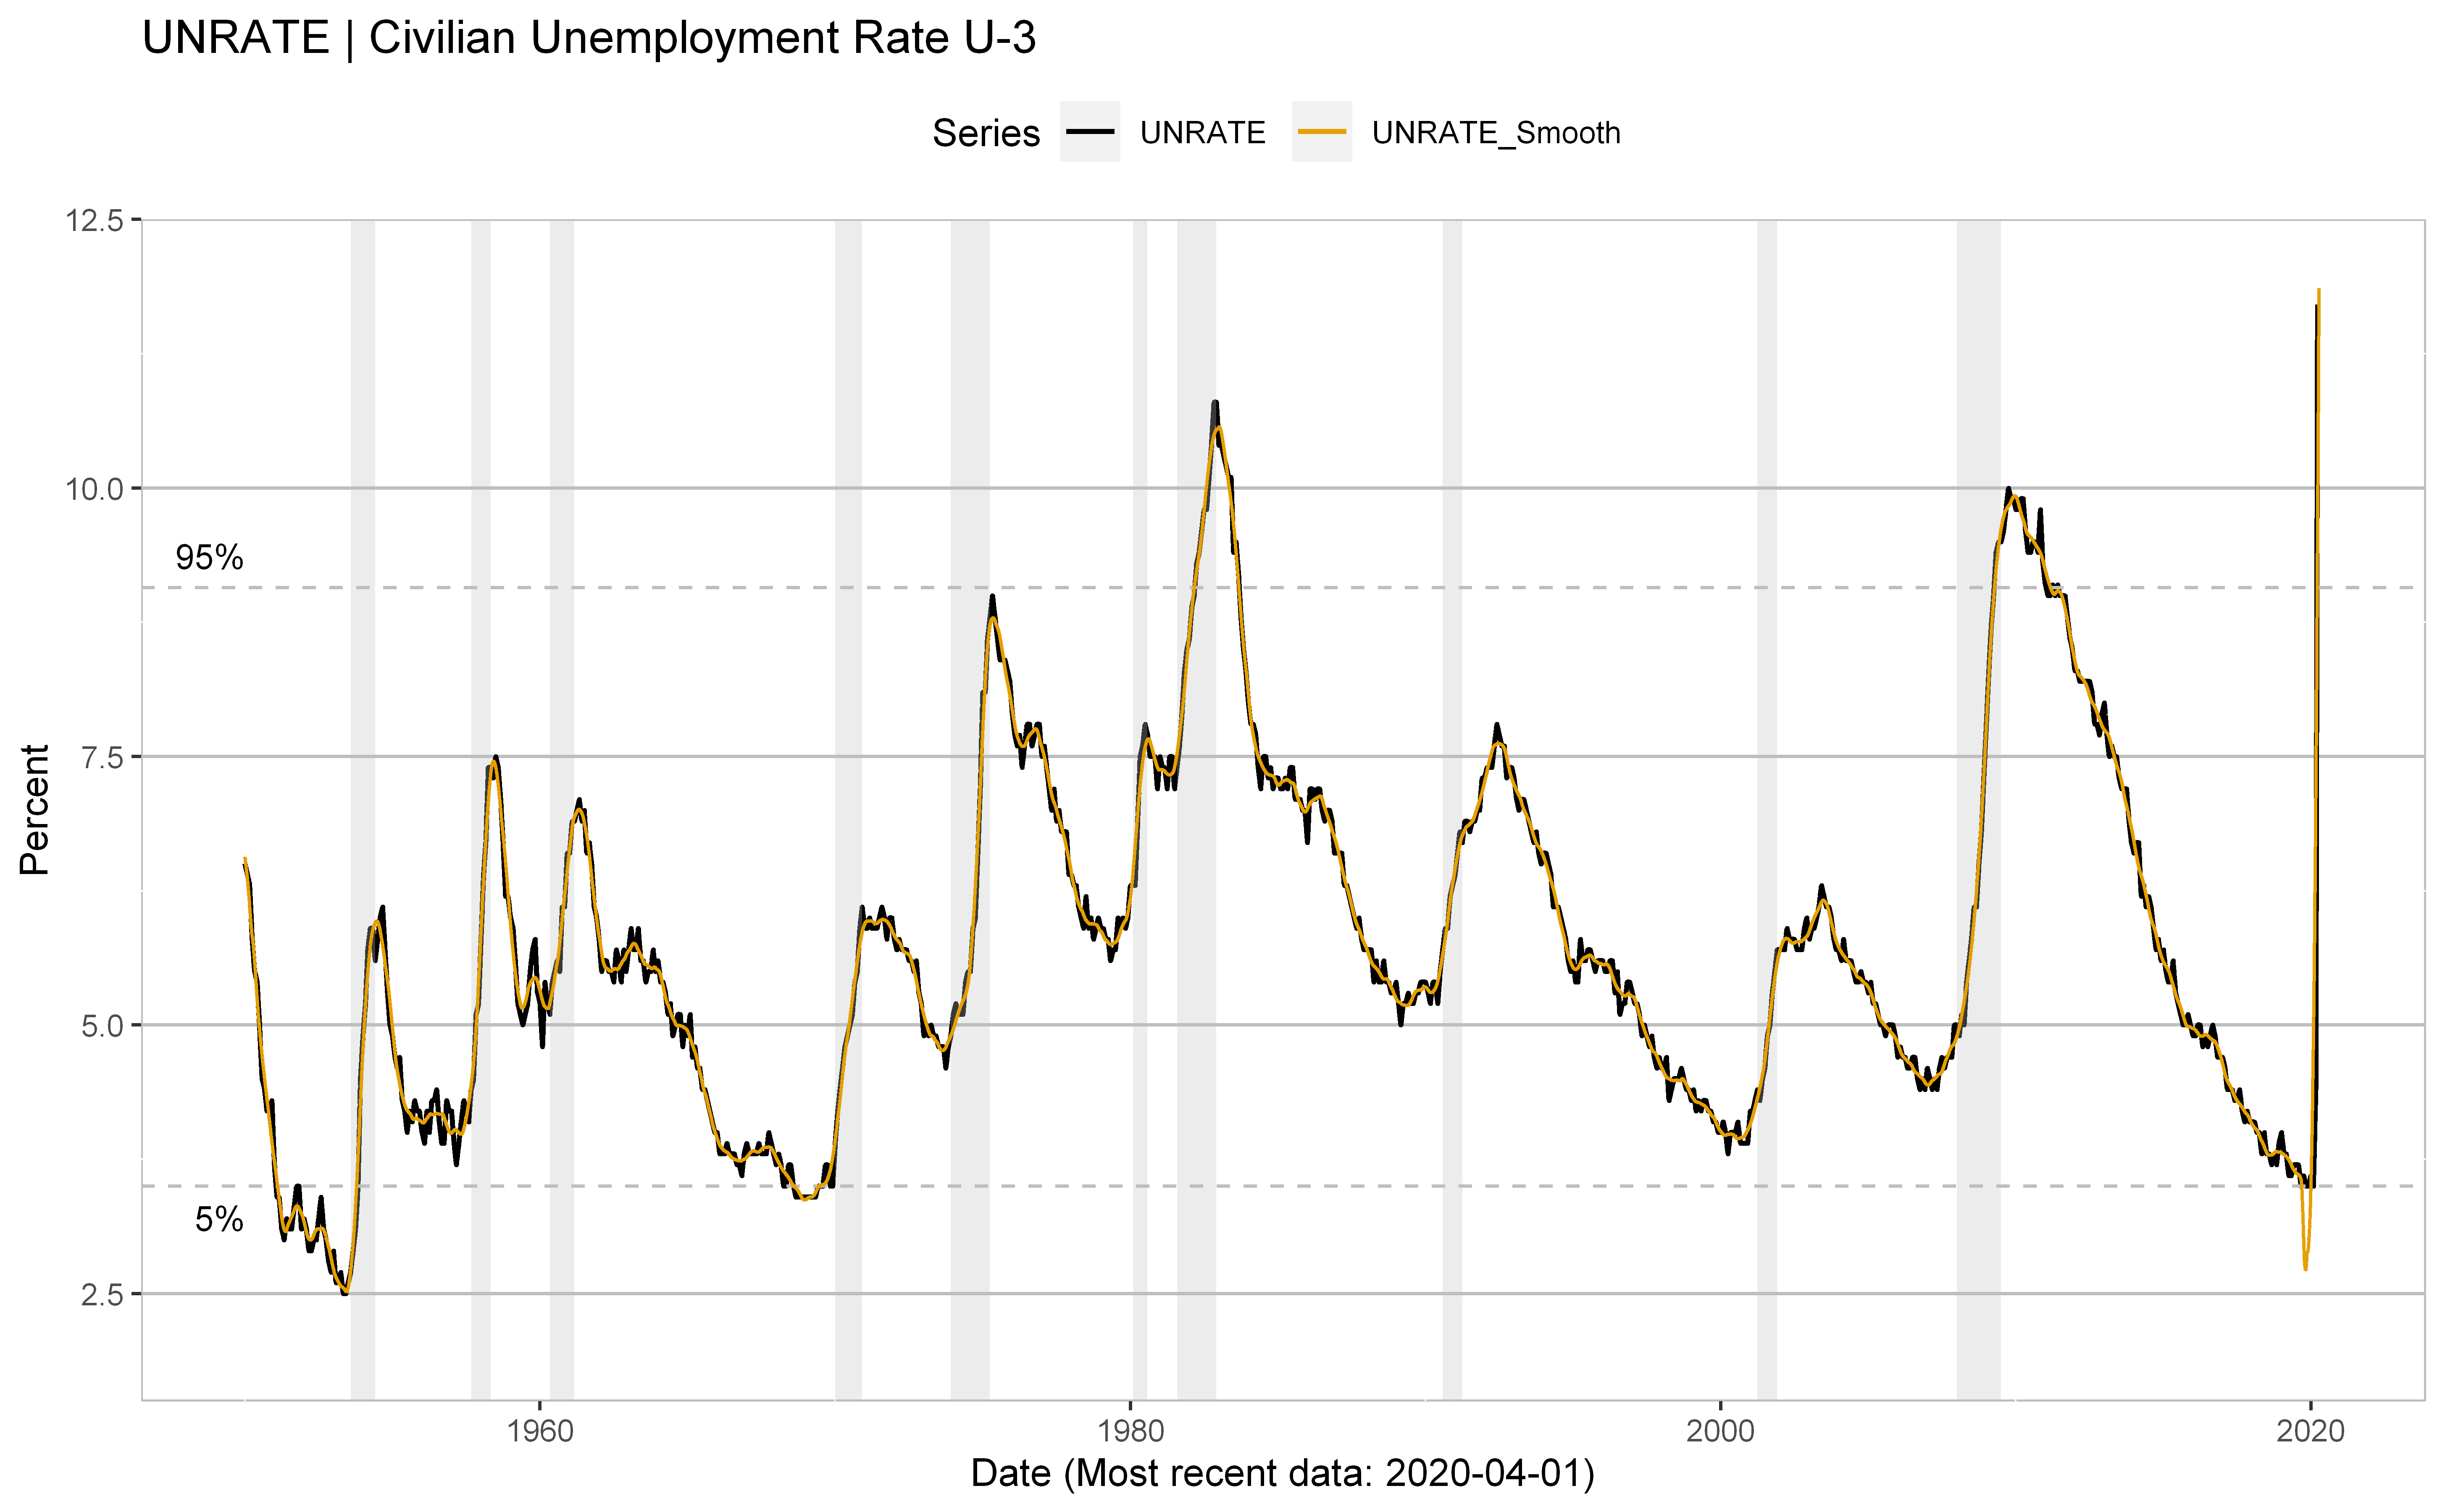

In [18]:
options(repr.plot.width = 9.7, repr.plot.height = 6, repr.plot.res = 600)
datay <- "CLF16OV.lm.POPTHM"
datay.aux <- "CLF16OV"
ylim <- c(0, 200000)
dt.end <- Sys.Date()
myPlot <-
  plotSingle(
    dfRecession,
    df.data,
    "date",
    datay,
    "CLF16OV Compared to CLF16OV predicted using overall population, POPTHM",
    "Date",
    getPlotYLabel(df.symbols, datay),
    c(dt.start.prediction, dt.end),
    ylim,
    b.legend = TRUE,
    b.percentile = FALSE,
    b.long.legend = TRUE
  )
myPlot <- myPlot + geom_line(
  data = df.data,
  aes_string(
    x = "date",
    y = datay.aux,
    colour = shQuote(getPlotTitle(df.symbols, datay.aux))
  ),
  na.rm = TRUE
)

print(myPlot)

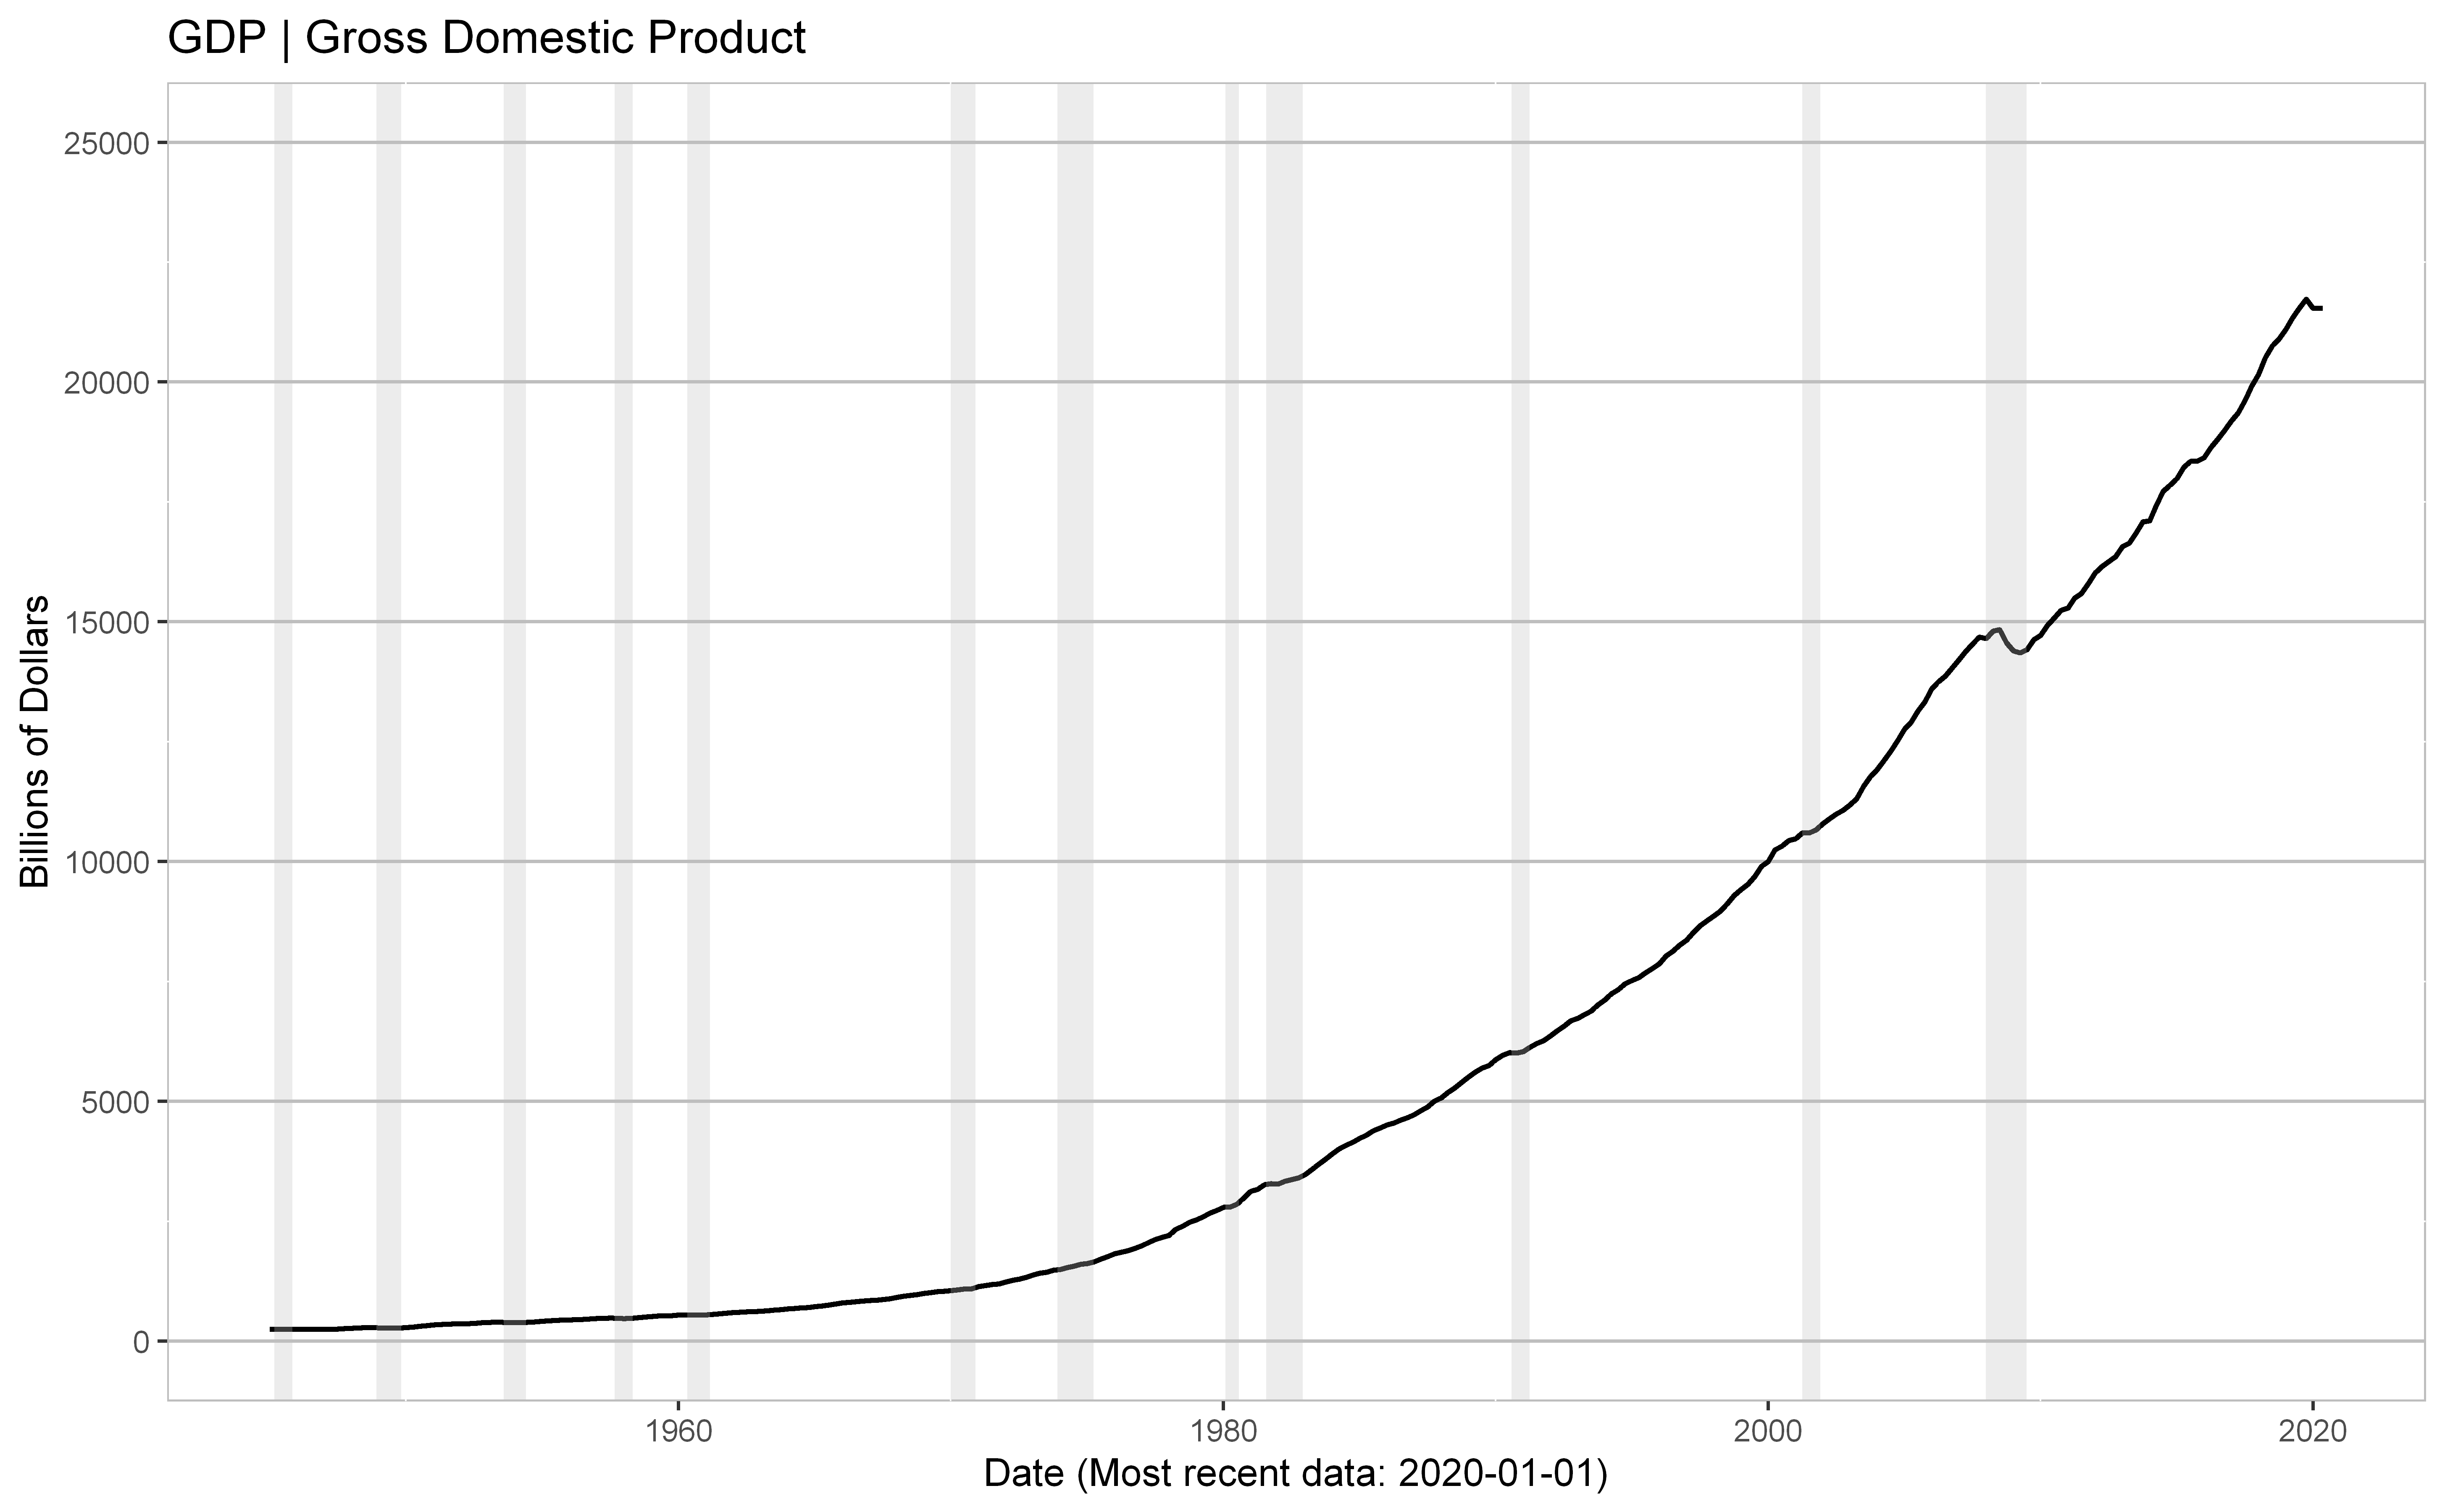

In [19]:
options(repr.plot.width = 9.7, repr.plot.height = 6, repr.plot.res = 600)
datay <- "GDP"
ylim <- c(1, 25000)
plotSingleQuick(dfRecession, df.data, datay, ylim)

In [20]:
df.data$CPROFIT.by.GDP <- (df.data$CPROFIT / df.data$GDP) * 100

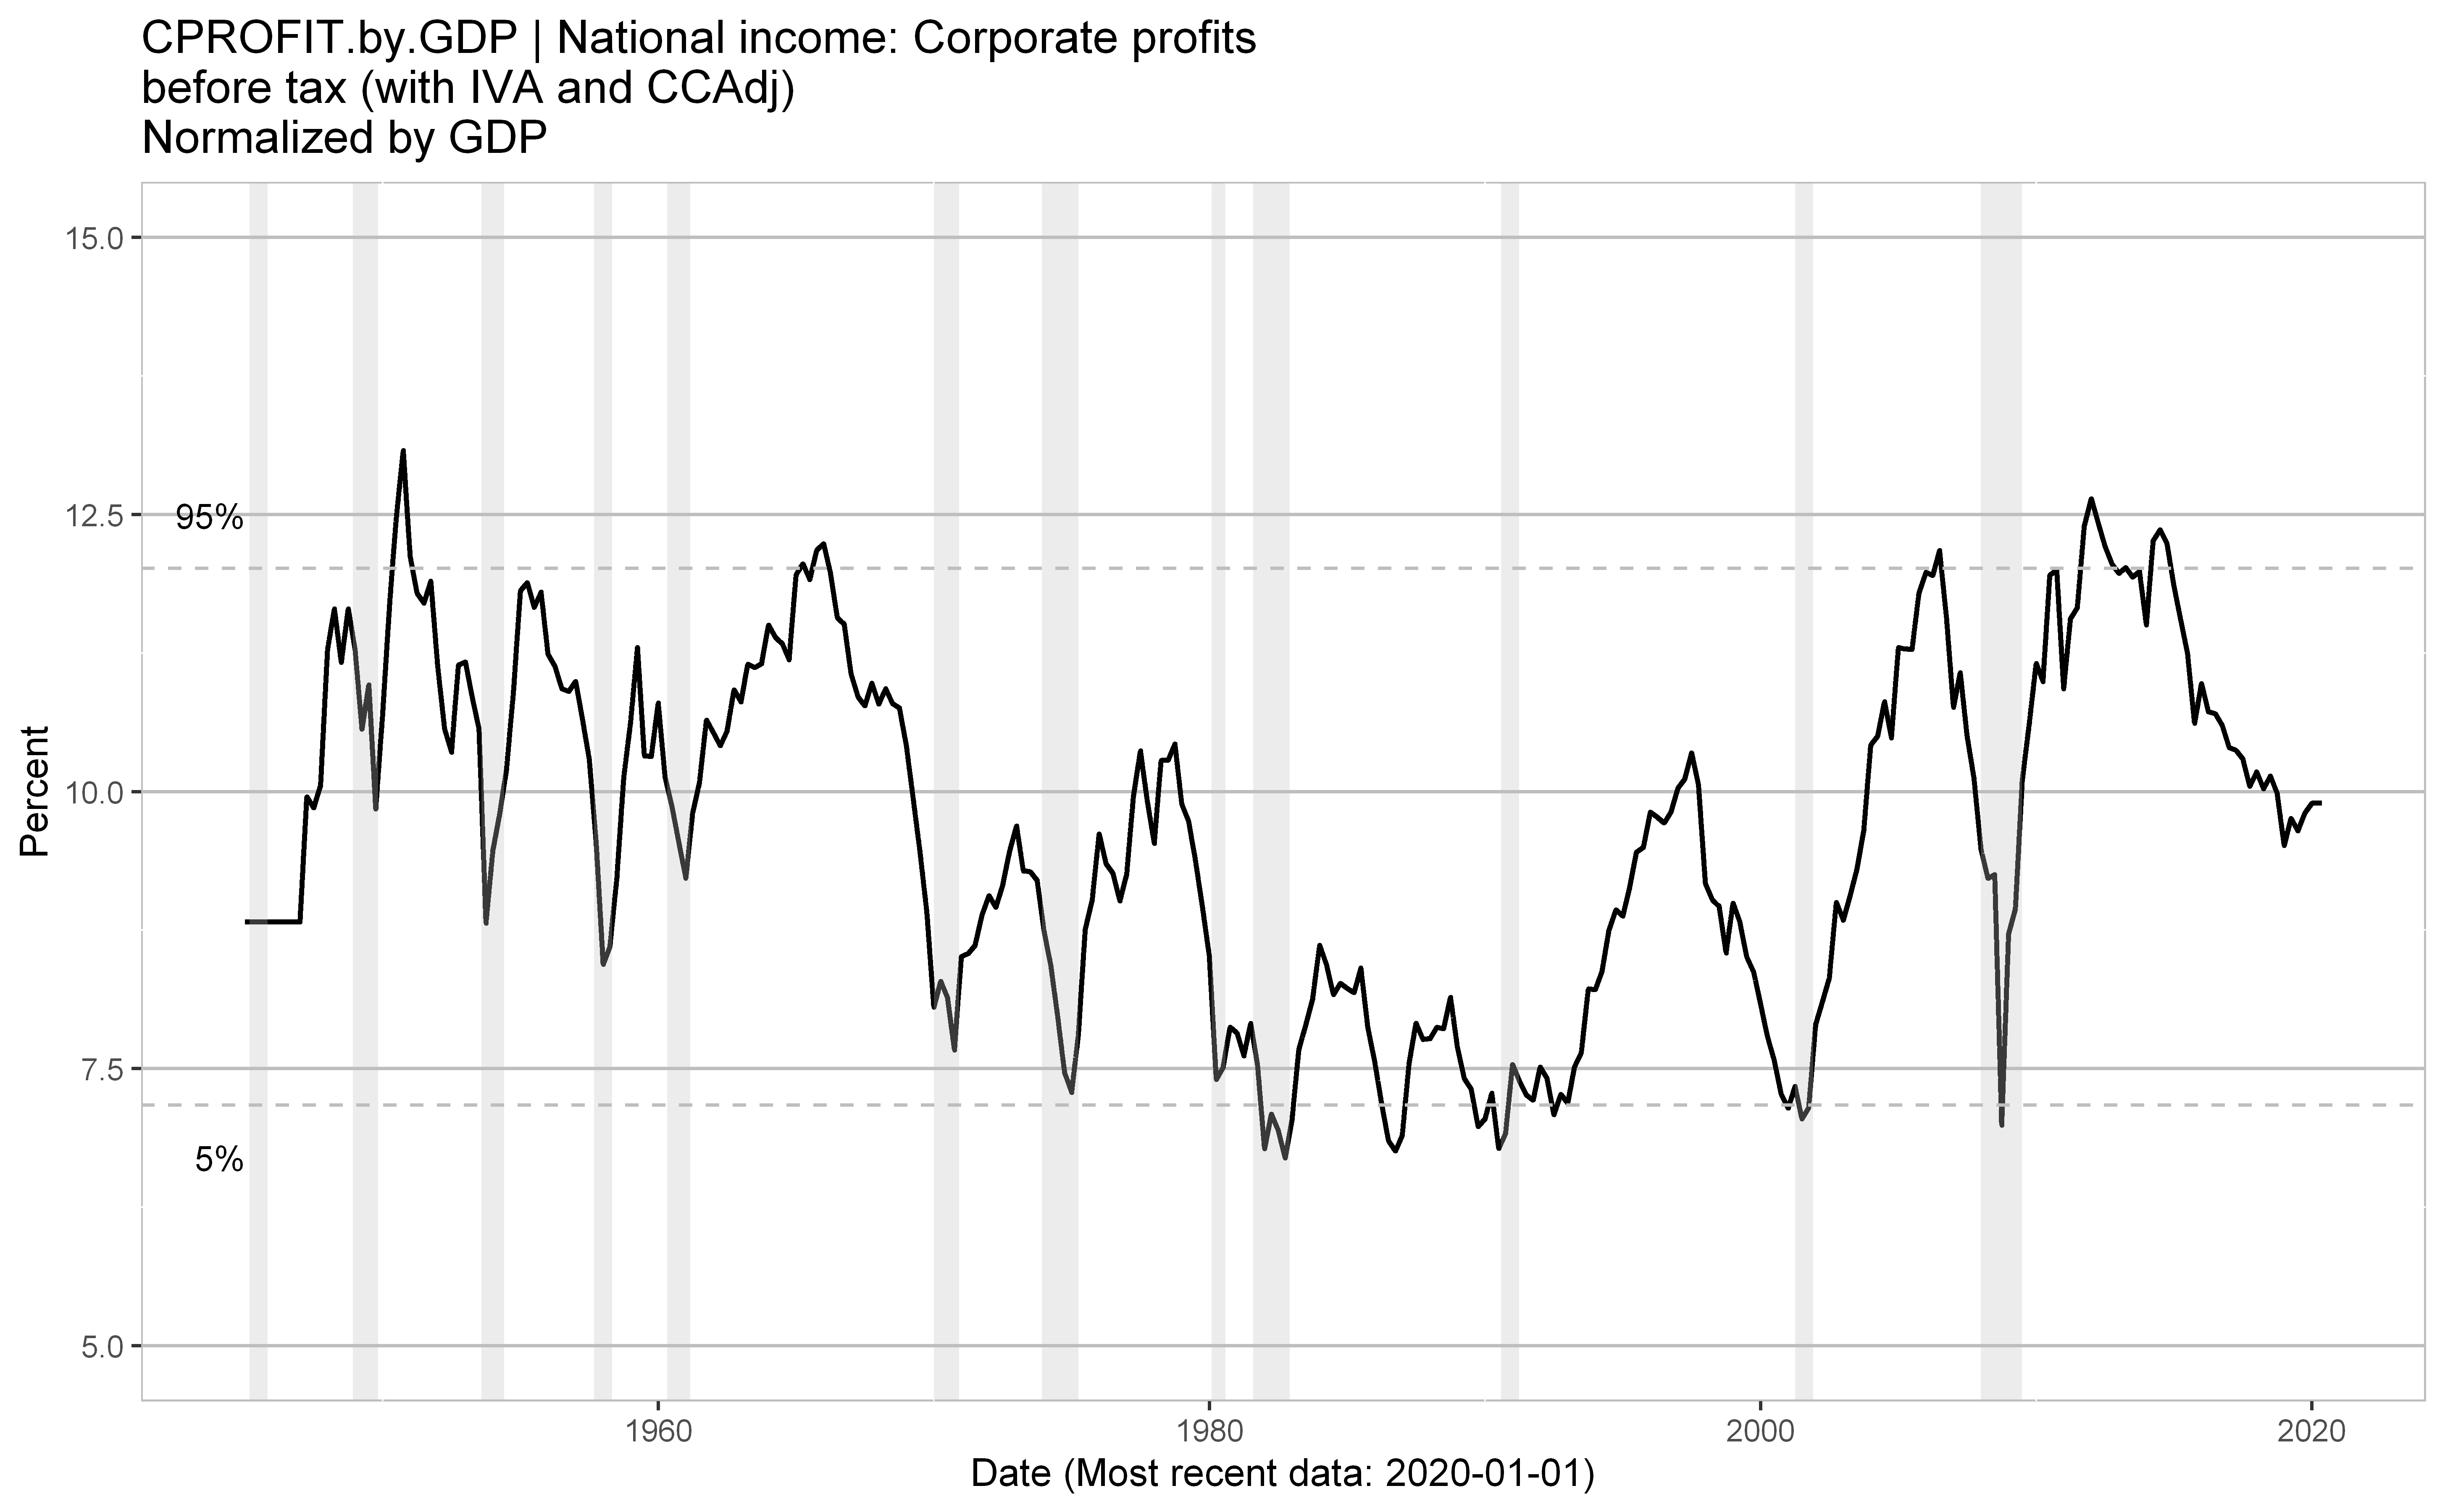

In [21]:
options(repr.plot.width = 9.7, repr.plot.height = 6, repr.plot.res = 600)
datay <- "CPROFIT.by.GDP"
ylim <- c(5, 15)
plotSingleQuick(dfRecession, df.data, datay, ylim, b.percentile = TRUE)

In [22]:
# Get S&P 500 Silverblatt data. From USDA website:
# https://us.spindices.com/documents/additional-material/sp-500-eps-est.xlsx

# Read in th Excel file
df.silverblatt <- data.frame(read_excel('sp-500-eps-est.xlsx', range='QUARTERLY DATA!A6:E133'))

# Human readable column names
colnames(df.silverblatt) <- c("QUARTER.END", "DIVISOR", "OP.EARNINGS.PER.SHARE", "AR.EARNINGS.PER.SHARE","CASH.DIVIDENDS.PER.SHR")

# Create the XTS object and update the symbols table
str.symbol <- 'OP.EARNINGS.PER.SHARE'
assign(str.symbol, xts(x=df.silverblatt$OP.EARNINGS.PER.SHARE, order.by=df.silverblatt$QUARTER.END))

df.symbols <-
  rbind(
    df.symbols,
    data.frame(
      string.symbol = str.symbol,
      string.source = "SILVERBLATT",
      string.description =  "Operating Earnings per Share",
      string.label.y = "Dollars",
      float.expense.ratio = -1.00,
      date.series.start = dt.date[1],
      date.series.end = tail(dt.date,1)
    )
  )


New names:
* `PER SHR` -> `PER SHR...3`
* `PER SHR` -> `PER SHR...4`
* `PER SHR` -> `PER SHR...5`



ERROR: Error in rbind(deparse.level, ...): numbers of columns of arguments do not match


In [ ]:
OP.EARNINGS.PER.SHARE